![](chi.jpg)

# Call Volume Prediction

Childline Kenya works in partnership with the Government to STOP child abuse and provide a safe environment for all children. They offer the only nationwide helpline service dedicated to children that runs 24 hours toll free, and is accessible by simply dialing 116.

The objective of this project is to create a forecast model to predict the number of incoming calls that Childline Kenya will receive per hour per day. Forecasting will help Childline manage its resources and staff their call center more efficiently, enabling them to better serve as many children as possible.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.simplefilter('ignore')
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)

In [3]:
data = pd.read_csv('D:/DS/Mtoto News Childline Kenya Call Volume Prediction/train.csv')
test = pd.read_csv('D:/DS/Mtoto News Childline Kenya Call Volume Prediction/Sample_Submission.csv')

In [4]:
data.head()

,calldate,cc_status,maincat,subcat1,casepriority,referal,caller_gender,caller_age,caller_county,child_age,child_gender,child_county,parent_age,parent_gender,parent_county,Abuser_Relationship,Neglector_Relationship,Perpetrator_Relationship,Physical abuser_Relationship
0,2016-01-01 07:26:47,Closed,non-interventional,Blank call,Non Critical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01 07:32:30,Closed,non-interventional,Blank call,Non Critical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-01 07:44:31,Closed,non-interventional,Blank call,Non Critical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-01 07:46:13,Closed,others,Unrelated to remit of Childline 116,Non Critical,NaN,Male,Adult,Nyeri,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-01 07:47:22,Closed,non-interventional,Blank call,Non Critical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data.isnull().sum()

calldate                             0
cc_status                            0
maincat                              0
subcat1                              0
casepriority                         0
referal                         134726
caller_gender                   124440
caller_age                      125256
caller_county                   127321
child_age                       132009
child_gender                    131996
child_county                    132239
parent_age                      135955
parent_gender                   135919
parent_county                   135940
Abuser_Relationship             135748
Neglector_Relationship          135840
Perpetrator_Relationship        135858
Physical abuser_Relationship    135875
dtype: int64

In [6]:
test.head()

,time_index,calls
0,2016071300,28.0
1,2016071301,98.0
2,2016071302,NaN
3,2016071303,NaN
4,2016071304,NaN


#### Data Preprocessing

In [7]:
data = data.iloc[:,0:1]
data.head()

,calldate
0,2016-01-01 07:26:47
1,2016-01-01 07:32:30
2,2016-01-01 07:44:31
3,2016-01-01 07:46:13
4,2016-01-01 07:47:22


In [8]:
data['calldate'] =pd.to_datetime(data.calldate)
data.calldate.dtype

dtype('<M8[ns]')

In [9]:
for i in data.calldate:

    def hour_rounder(t):
        # Rounds to nearest hour by adding a timedelta hour if minute >= 30
        return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
                   +timedelta(hours=t.minute//60))


print(hour_rounder(i))

2016-07-12 23:00:00


In [10]:
data['ds'] = data.apply(lambda x: hour_rounder(x['calldate']), axis=1)

In [11]:
data.drop('calldate',axis=1,inplace=True)
data.insert(1,value=1,column='call')
data.head()

,ds,call
0,2016-01-01 07:00:00,1
1,2016-01-01 07:00:00,1
2,2016-01-01 07:00:00,1
3,2016-01-01 07:00:00,1
4,2016-01-01 07:00:00,1


In [12]:
data = data.groupby('ds').count().reset_index().rename(columns={'call':'y'})
data.head()

,ds,y
0,2016-01-01 07:00:00,8
1,2016-01-01 08:00:00,41
2,2016-01-01 09:00:00,20
3,2016-01-01 10:00:00,34
4,2016-01-01 11:00:00,44


In [13]:
data.shape

(3697, 2)

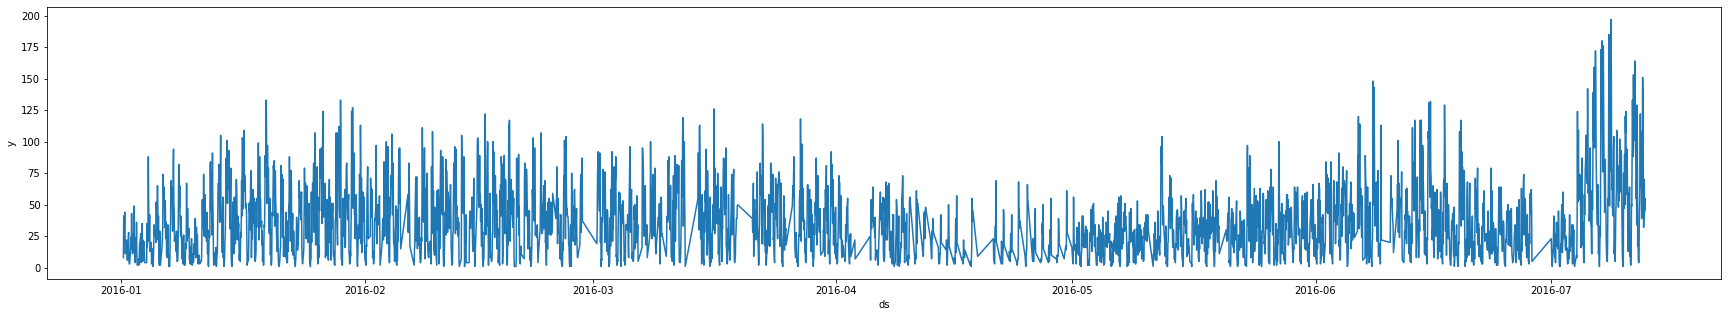

In [14]:
plt.figure(figsize = (30,5))
sns.lineplot(x = 'ds', y='y', data=data)

##### It seems like there is missing hours in the dataset and also some impact of holidays and school off days.

I will use fbprophet for this problem, Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

#### Enlisting holidays and school off days.

In [15]:
holidays = pd.DataFrame({
  'holiday': 'holiday',
  'ds': pd.to_datetime(['2016-01-01', '2016-03-25', '2016-03-28',
                        '2016-05-01', '2016-05-02', '2016-06-01',
                        '2016-07-07'])
})
school_off = pd.DataFrame({
    'holiday': 'school_off',
    'ds' : pd.to_datetime(['2016-01-02','2016-01-03','2016-04-09','2016-04-10','2016-04-11','2016-04-12','2016-04-13',
                          '2016-04-14','2016-04-15','2016-04-16','2016-04-17','2016-04-18','2016-04-19','2016-04-20',
                          '2016-04-21','2016-04-22','2016-04-23','2016-04-24','2016-04-25','2016-04-26','2016-04-27',
                          '2016-04-28','2016-04-29','2016-04-30','2016-08-06','2016-08-07','2016-08-08',
                           '2016-08-09','2016-08-10','2016-08-11','2016-08-12','2016-08-13','2016-08-14','2016-08-15',
                           '2016-08-16','2016-08-17','2016-08-18','2016-08-19','2016-08-20','2016-08-21','2016-08-22',
                           '2016-08-23','2016-08-24','2016-08-25','2016-08-26','2016-08-27','2016-08-28','2016-08-29',
                           '2016-08-30','2016-08-31','2016-09-01','2016-09-02','2016-09-03','2016-09-04'])
})

holidays=pd.concat((holidays,school_off))

#### Prophet model to predict hourly call volume.

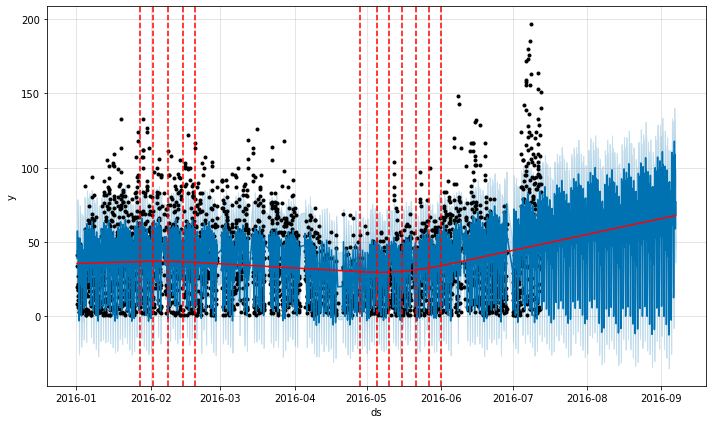

In [16]:
m = Prophet(changepoint_prior_scale=0.005, 
            changepoint_range=0.8,
            seasonality_mode='multiplicative',
            interval_width=0.7,
            holidays=holidays).fit(data)
future = m.make_future_dataframe(periods=1344, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)
from fbprophet.plot import add_changepoints_to_plot
a = add_changepoints_to_plot(fig.gca(), m, fcst)

In [17]:
print('Model Report:')
print('---------------')
fcst_y = fcst.loc[0:3696,['yhat']]
fcst_y = np.round(fcst_y).astype(int)
fcst_y = [0 if i<0 else i for i in fcst_y.yhat]
y = data['y']
rmse_tr = sqrt(mean_squared_error(y, fcst_y))
print('Training RMSE:',rmse_tr)

Model Report:
---------------
Training RMSE: 21.443252824512648


#### Cross validation for the model

In [18]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='2000 h', period='240 h', horizon = '48 h')
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-04-02 00:00:00,21.298477,0.528745,44.285913,9,2016-04-01 23:00:00
1,2016-04-02 01:00:00,6.206122,-14.643023,27.092653,9,2016-04-01 23:00:00
2,2016-04-02 02:00:00,-1.023115,-22.181073,20.211581,8,2016-04-01 23:00:00
3,2016-04-02 03:00:00,1.834832,-19.971149,24.348140,5,2016-04-01 23:00:00
4,2016-04-02 04:00:00,10.586475,-11.497040,32.219303,10,2016-04-01 23:00:00


#### Hourly basis performance metrics for the model.

In [19]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
0,05:00:00,62.450792,7.902581,6.237774,1.166595,1.000000
1,06:00:00,86.118430,9.280002,7.139775,1.065742,0.952381
2,07:00:00,96.575496,9.827283,7.562455,1.054907,0.928571
3,08:00:00,149.449613,12.224959,9.220648,0.853588,0.904762
4,09:00:00,392.016993,19.799419,12.929908,0.540355,0.809524


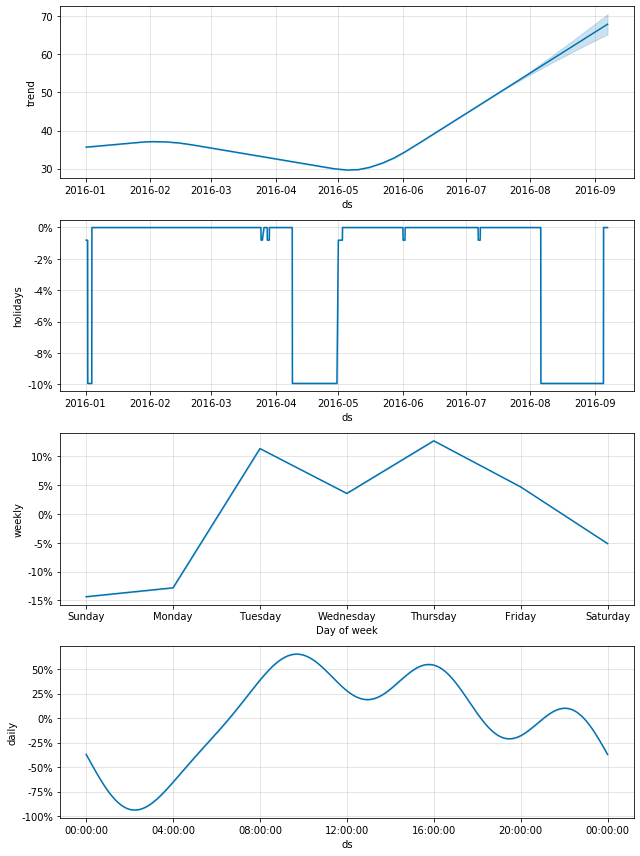

In [20]:
m.plot_components(fcst);

## Component analysis
Tuesday and thursday are busy day for them
<br>8 to 12 is peak hour
<br>Impact of holidays and school off is clearly visiable in holidays graph.


#### Forecasted call volime with upper and lower limit

In [22]:
forecasted_call_volume = fcst.loc[:,['ds','yhat_lower','yhat_upper','yhat']]
forecasted_call_volume.head()

,ds,yhat_lower,yhat_upper,yhat
0,2016-01-01 07:00:00,17.424048,60.771512,39.011080
1,2016-01-01 08:00:00,26.604571,69.399833,48.758247
2,2016-01-01 09:00:00,33.592084,77.134318,56.238610
3,2016-01-01 10:00:00,34.883880,78.876639,57.509497
4,2016-01-01 11:00:00,30.734094,74.285023,51.966838
